# Detecting Motor Anomalies

Preventing motor anomalies is a bit more complicated than battery issues. Usually, motors operate in a certain range of power, but sometimes they may present anomalous behavior. Their power consumption can go to high, due to environmental issues, or too low, due to aging issues.

As usual, let's start by recovering and looking at data:

In [21]:
%store -r data
data.head()

,device_id,motor_peak_mA,battery
timestamp,,,
2020-02-22 23:59:59,7517a917b42450470661cec1bd4654f8,1335,73
2020-02-22 23:59:59,8e4a851ed2317a249a0903f29d894361,1577,73
2020-02-22 23:59:59,572ddf9d82d5675ed2db832081b70103,1585,73
2020-02-22 23:59:59,b17bbc29ce61265a6212c689a597d4d8,0,73
2020-02-22 23:59:59,19d3c55b134ab7780d2b711211b7cf7c,1286,73


In [22]:
%store -r bucket
bucket

'mt-ml-workshop-yuixc09t'

# Exploratory Data Analysis

In [23]:
train_data = data[["motor_peak_mA"]]
train_data = train_data[train_data["motor_peak_mA"] > 0]
train_data.head()

,motor_peak_mA
timestamp,
2020-02-22 23:59:59,1335
2020-02-22 23:59:59,1577
2020-02-22 23:59:59,1585
2020-02-22 23:59:59,1286
2020-02-22 23:59:59,1796


In [24]:
train_data.describe()

,motor_peak_mA
count,3.079934e+06
mean,5.250616e+02
std,6.858781e+02
min,9.000000e+00
25%,1.000000e+01
50%,2.100000e+01
75%,7.970000e+02
max,7.730000e+03


train_data.info()

<AxesSubplot:xlabel='timestamp'>

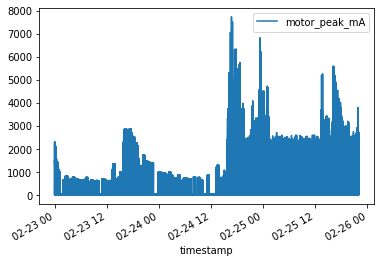

In [25]:
import matplotlib.pyplot as plt
train_data.plot(rot=30)

## Synthetic Ground Truth

In [26]:
anomalies = data[["motor_peak_mA"]]
anomalies = anomalies[anomalies["motor_peak_mA"] > 0]
anomalies.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3079934 entries, 2020-02-22 23:59:59 to 2020-02-25 22:03:11
Data columns (total 1 columns):
 #   Column         Dtype
---  ------         -----
 0   motor_peak_mA  int64
dtypes: int64(1)
memory usage: 47.0 MB


In [27]:
from sklearn.model_selection import train_test_split

train_data, test_dataframe = train_test_split(anomalies, test_size=0.2)

In [28]:
test_data = test_dataframe.copy()
test_data["anomaly"] = test_data["motor_peak_mA"] > 4000
test_data["anomaly"] = test_data["anomaly"] | (test_data["motor_peak_mA"] > 50) & (test_data["motor_peak_mA"] < 200)
test_data["anomaly"] = test_data["anomaly"].astype(int) 
test_data.groupby("anomaly").count().head()

,motor_peak_mA
anomaly,
0,615630
1,357


In [29]:
test_data.describe()

,motor_peak_mA,anomaly
count,615987.000000,615987.000000
mean,524.780765,0.000580
std,685.004389,0.024067
min,9.000000,0.000000
25%,10.000000,0.000000
50%,21.000000,0.000000
75%,796.000000,0.000000
max,7730.000000,1.000000


In [30]:
train_data.describe()

,motor_peak_mA
count,2.463947e+06
mean,5.251318e+02
std,6.860965e+02
min,9.000000e+00
25%,1.000000e+01
50%,2.100000e+01
75%,7.980000e+02
max,6.820000e+03


# Random Cut Forest Training

In [31]:
train_array = train_data.values
train_array

array([[   9],
       [ 376],
       [1425],
       ...,
       [1657],
       [ 768],
       [  21]])

In [32]:
test_array = test_data[["motor_peak_mA"]].values
test_array

array([[  10],
       [   9],
       [1361],
       ...,
       [  10],
       [  10],
       [   9]])

In [33]:
labels_array = test_data["anomaly"].values
labels_array

array([0, 0, 0, ..., 0, 0, 0])

In [37]:
import io
import numpy as np
import sagemaker
import sagemaker.amazon.common as smac
import boto3

s3bucket = boto3.resource('s3').Bucket(bucket)

def upload_records(array,key,labels=None):
    result = {} 
    buf = io.BytesIO()
    if (labels is not None):
        smac.write_numpy_to_dense_tensor(buf, array, labels)
    else:
        smac.write_numpy_to_dense_tensor(buf, array)
    buf.seek(0)
    s3bucket.Object(key).upload_fileobj(buf)


In [38]:
import os

s3 = boto3.client("s3")
prefix = "mt-motor-anomaly" 

cwd = os.getcwd()
train_key  = "{}/input/{}".format(prefix,"train.rio")
test_key  = "{}/input/{}".format(prefix, "test.rio")

upload_records(train_array,train_key)
upload_records(test_array,test_key,labels_array)

train_input = sagemaker.inputs.TrainingInput(
       s3_data="s3://{}/{}".format(bucket,train_key),
       content_type='application/x-recordio-protobuf',
       distribution='ShardedByS3Key')

test_input = sagemaker.inputs.TrainingInput(
       s3_data="s3://{}/{}".format(bucket,test_key),
       content_type='application/x-recordio-protobuf',
       distribution='FullyReplicated')

rcf_input = {
    'train': train_input,
    'test': test_input     
}

rcf_input

{'train': <sagemaker.inputs.TrainingInput at 0x7f6320046c88>,
 'test': <sagemaker.inputs.TrainingInput at 0x7f62f2a43240>}

# RCF Training

In [39]:
region = boto3.Session().region_name
from sagemaker.amazon.amazon_estimator import get_image_uri

region = boto3.Session().region_name
rcf_container = sagemaker.image_uris.retrieve('randomcutforest', region)
rcf_container

'174872318107.dkr.ecr.us-west-2.amazonaws.com/randomcutforest:1'

In [40]:
rcf_hparams = {
    "num_samples_per_tree":512,
    "num_trees":50,
    "feature_dim":1,
    "eval_metrics": "accuracy"
}

In [42]:
rcf_estimator = sagemaker.estimator.Estimator(
                      rcf_container,
                      role=sagemaker.get_execution_role(),
                      instance_count=1,
                      instance_type='ml.m5.large',
                      base_job_name="mt-motor-anomaly",
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      hyperparameters = rcf_hparams )

In [43]:
rcf_estimator.fit(rcf_input)

2021-05-14 09:28:00 Starting - Starting the training job...
2021-05-14 09:28:24 Starting - Launching requested ML instancesProfilerReport-1620984480: InProgress
......
2021-05-14 09:29:24 Starting - Preparing the instances for training......
2021-05-14 09:30:27 Downloading - Downloading input data
2021-05-14 09:30:27 Training - Downloading the training image......
2021-05-14 09:31:27 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/14/2021 09:31:31 INFO 140391792658240] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'num_samples_per_tree': 256, 'num_trees': 100, 'force_dense': 'true', 'eval_metrics': ['accuracy', 'precision_recall_fscore'], 'epochs': 1, 'mini_batch_size': 1000, '_log_level': 'info', '_kvstore': 'dist_async', '_num_kv_servers': 'auto', '_num_gpus': 'auto', '_tuning_objective_metric': 

In [44]:
print('Training job name: {}'.format(rcf_estimator.latest_training_job.job_name))

Training job name: mt-motor-anomaly-2021-05-14-09-28-00-719


In [45]:
rcf_inference = rcf_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
)

---------------!

In [48]:
rcf_inference_endpoint = rcf_inference.endpoint_name
%store rcf_inference_endpoint
rcf_inference_endpoint

Stored 'rcf_inference_endpoint' (str)


'mt-motor-anomaly-2021-05-14-09-34-07-728'

In [50]:
from sagemaker.predictor import csv_serializer, json_deserializer


rcf_inference.serializer = sagemaker.serializers.CSVSerializer()
rcf_inference.deserializer = sagemaker.deserializers.JSONDeserializer()

In [51]:
sample_data = train_data[:5].values
sample_data

array([[   9],
       [ 376],
       [1425],
       [   9],
       [  10]])

In [52]:
results = rcf_inference.predict(sample_data)
results

{'scores': [{'score': 0.7336624496},
  {'score': 0.8975967338},
  {'score': 0.8770466595},
  {'score': 0.7336624496},
  {'score': 0.7292955209}]}

In [53]:
import pandas as pd
sigmas = 1

scores = results["scores"]
scores = [score["score"] for score in scores]
series = pd.Series(scores)
score_mean = series.mean()
score_max = series.max()
score_std = series.std()
score_cutoff = score_mean + sigmas*score_std
(score_mean,score_max,score_std,score_cutoff)

(0.79425276268, 0.8975967338, 0.08528865847142635, 0.8795414211514263)

In [54]:
anomalies = series[series > score_cutoff ]  
anomalies

1    0.897597
dtype: float64

In [55]:
"{} anomalies detected".format(len(anomalies))

'1 anomalies detected'

## Motor Maintenance

Now that we can detect anomalies in past data, let's combine that with forecasting for predictive [motor maintenance](mt-motor-maintenance.ipynb).